# 1. Imports

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

# 2. Plotting Tool

In [3]:
def plot_series(x, y, format="-", start=0, end=None, title=None, xlabel=None, ylabel=None, legend=None ):
    plt.figure(figsize=(10, 6))
    
    if type(y) is tuple:
        for y_curr in y:
            plt.plot(x[start:end], y_curr[start:end], format)

    else:
        plt.plot(x[start:end], y[start:end], format)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    if legend:
        plt.legend(legend)

    plt.title(title)
    plt.grid(True)
    plt.show()

# 3. Download the Dataset

In [4]:
!wget --no-check-certificate \
    "https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv" \
    -O "./data/Sunspots.csv"

--2023-11-16 22:29:41--  https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.187.219, 216.58.213.27, 142.250.187.251, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.187.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [text/csv]
Saving to: ‘./data/Sunspots.csv’

./data/Sunspots.csv 100%[===================>]  69.17K  --.-KB/s    in 0.09s   

2023-11-16 22:29:42 (800 KB/s) - ‘./data/Sunspots.csv’ saved [70827/70827]



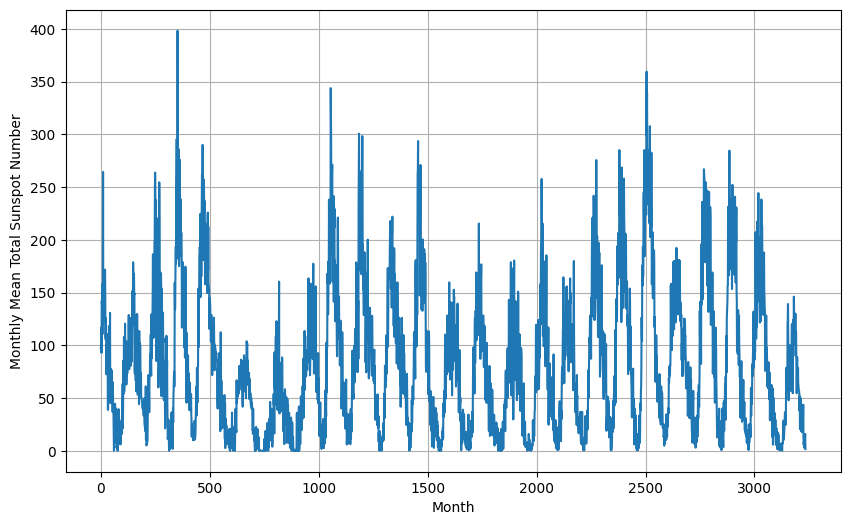

In [5]:
# Initialize lists
time_step = []
sunspots = []

# Open CSV file
with open('./data/Sunspots.csv') as csvfile:
  
  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')
  
  # Skip the first line
  next(reader)
  
  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    sunspots.append(float(row[2]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(sunspots)

# Preview the data
plot_series(time, series, xlabel='Month', ylabel='Monthly Mean Total Sunspot Number')

# 4. Split the Dataset

In [6]:
# Define the split time
split_time = 3000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

# 5. Prepare Features and Labels

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # Generate a TF dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data by only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows 
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [8]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# 6. Build the Model

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, activation='relu', padding='causal', input_shape=[window_size,1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 30, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 30, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
 lambda (Lambda)             (None, 1)                 0

# 7. Tune the Learning Rate

In [11]:
# Get initial weights to reset model after getting optimal learning rate
init_weights = model.get_weights()

In [12]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 1**(epoch / 20))

optimizer = tf.keras.optimizers.legacy.SGD(momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
93/93 [==============================] - 3s 15ms/step - loss: 68.1752 - lr: 1.0000e-08
Epoch 2/100
93/93 [==============================] - 1s 15ms/step - loss: 52.6900 - lr: 1.0000e-08
Epoch 3/100
93/93 [==============================] - 1s 15ms/step - loss: 44.1786 - lr: 1.0000e-08
Epoch 4/100
93/93 [==============================] - 1s 15ms/step - loss: 37.5604 - lr: 1.0000e-08
Epoch 5/100
93/93 [==============================] - 1s 15ms/step - loss: 32.3407 - lr: 1.0000e-08
Epoch 6/100
93/93 [==============================] - 1s 15ms/step - loss: 28.9063 - lr: 1.0000e-08
Epoch 7/100
93/93 [==============================] - 1s 15ms/step - loss: 26.9579 - lr: 1.0000e-08
Epoch 8/100
93/93 [==============================] - 1s 15ms/step - loss: 25.8203 - lr: 1.0000e-08
Epoch 9/100
93/93 [==============================] - 1s 15ms/step - loss: 25.2161 - lr: 1.0000e-08
Epoch 10/100
93/93 [==============================] - 1s 15ms/step - loss: 24.8883 - lr: 1.0000e-08
Epoch 11/

(1e-08, 0.001, 0.0, 100.0)

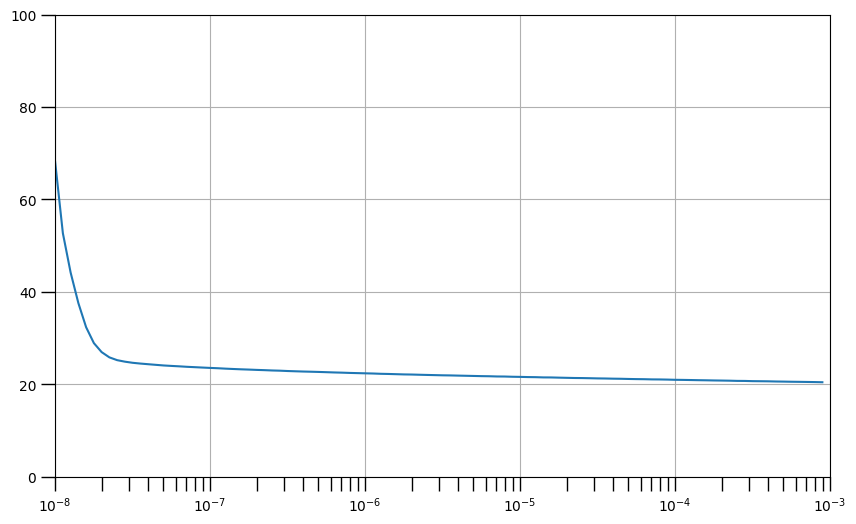

In [24]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

plt.figure(figsize=(10,6))
plt.grid(True)

# Used to create a plot with a logarithmic scale on the x-axis (lrs) and a linear scale on the y-axis (loss values
plt.semilogx(lrs, history.history['loss'])

plt.tick_params('both', length=10, width=1, which='both')

# Sets the limits for the x-axis (1e-8 to 1e-3) and y-axis (0 to 100) of the plot
plt.axis([1e-8, 1e-3, 0, 100])

# 8. Train the Model

In [26]:
# Reset states generated by keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [27]:
learning_rate = 8e-7

optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [28]:
history = model.fit(train_set, epochs=100)

Epoch 1/100
93/93 [==============================] - 3s 15ms/step - loss: 31.0376 - mae: 31.5323
Epoch 2/100
93/93 [==============================] - 1s 15ms/step - loss: 21.6852 - mae: 22.1775
Epoch 3/100
93/93 [==============================] - 1s 15ms/step - loss: 20.7846 - mae: 21.2774
Epoch 4/100
93/93 [==============================] - 1s 15ms/step - loss: 19.6706 - mae: 20.1631
Epoch 5/100
93/93 [==============================] - 1s 15ms/step - loss: 19.5764 - mae: 20.0683
Epoch 6/100
93/93 [==============================] - 1s 15ms/step - loss: 19.4902 - mae: 19.9815
Epoch 7/100
93/93 [==============================] - 1s 15ms/step - loss: 19.0755 - mae: 19.5683
Epoch 8/100
93/93 [==============================] - 1s 15ms/step - loss: 18.5763 - mae: 19.0694
Epoch 9/100
93/93 [==============================] - 1s 15ms/step - loss: 18.7124 - mae: 19.2050
Epoch 10/100
93/93 [==============================] - 1s 15ms/step - loss: 18.6422 - mae: 19.1341
Epoch 11/100
93/93 [=========

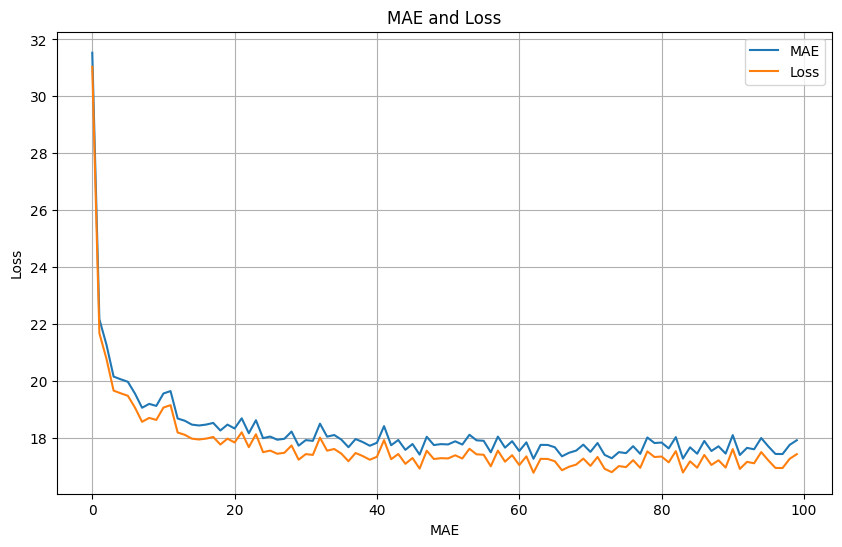

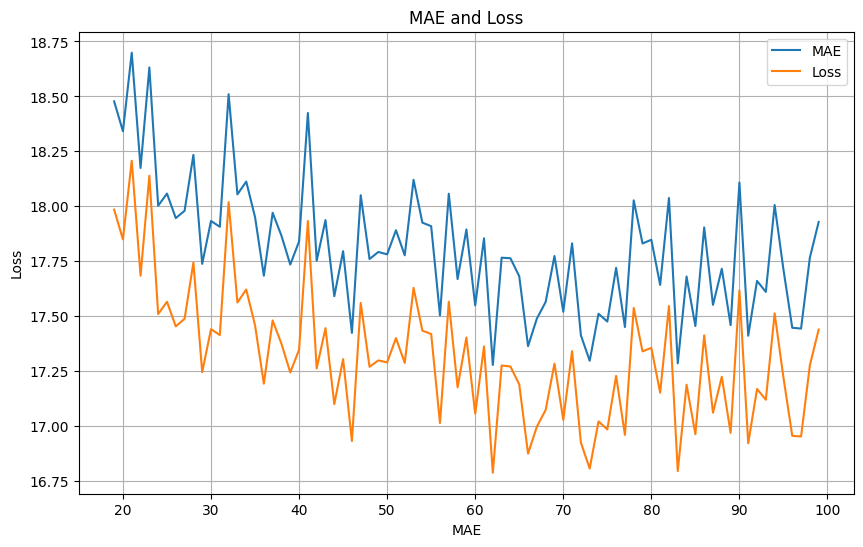

In [33]:
mae = history.history['mae']
loss = history.history['loss']

epochs = range(len(loss))

plot_series(
    x=epochs,
    y=(mae, loss),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE','Loss']
)

# plot the last 80% only
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

plot_series(
    x=epochs_zoom,
    y=(mae_zoom, loss_zoom),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE','Loss']
)

# 9. Model Predictions

In [34]:
def model_forecast(model, series, window_size, batch_size):
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

8/8 [==============================] - 0s 5ms/step


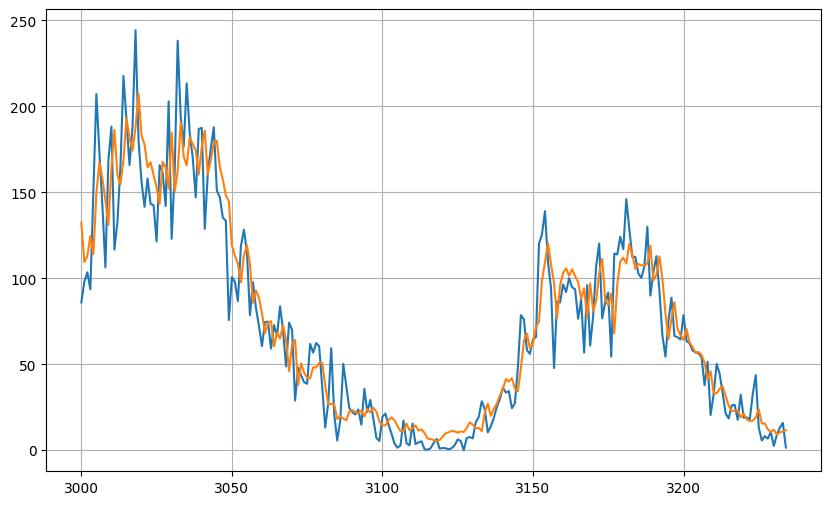

In [35]:
forecast_series = series[split_time-window_size:-1]

forecast = model_forecast(model, forecast_series, window_size, batch_size)

# drop single dimensional axis
results = forecast.squeeze()

plot_series(time_valid, (x_valid, results))

In [36]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

14.628481


# 10. Alternate way to dynamically set the learning rate

In [37]:
# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=10)

Epoch 1/10
93/93 [==============================] - 3s 16ms/step - loss: 16.4379 - mae: 16.9281
Epoch 2/10
93/93 [==============================] - 1s 15ms/step - loss: 16.4423 - mae: 16.9322
Epoch 3/10
93/93 [==============================] - 1s 15ms/step - loss: 16.3833 - mae: 16.8716
Epoch 4/10
93/93 [==============================] - 1s 15ms/step - loss: 16.3823 - mae: 16.8708
Epoch 5/10
93/93 [==============================] - 1s 15ms/step - loss: 16.4426 - mae: 16.9320
Epoch 6/10
93/93 [==============================] - 1s 14ms/step - loss: 16.3751 - mae: 16.8639
Epoch 7/10
93/93 [==============================] - 1s 15ms/step - loss: 16.3507 - mae: 16.8402
Epoch 8/10
93/93 [==============================] - 1s 15ms/step - loss: 16.3741 - mae: 16.8637
Epoch 9/10
93/93 [==============================] - 1s 15ms/step - loss: 16.3753 - mae: 16.8643
Epoch 10/10
93/93 [==============================] - 1s 15ms/step - loss: 16.4366 - mae: 16.9250


At some point, the static learning rate you set might no longer be the optimal one when the model has been learning for some time. You may want to decrease it some more to see better improvements. One way to do that is to have your training loop gradually decay the learning rate per epoch. You can pass in a lambda function similar like the one you did for the learning rate scheduler earlier, or use ExponentialDecay(). This is a built in scheduler from the Keras API. This decays the learning rate defined by this function:

```
def decayed_learning_rate(step):
  return initial_learning_rate * decay_rate ^ (step / decay_steps)
```

See how it is used below.

In [38]:
# Set the initial learning rate
initial_learning_rate=1e-7

# Define the scheduler - When staircase=True, the learning rate decays at discrete intervals
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=400,
    decay_rate=0.96,
    staircase=True)

# Set the optimizer
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=lr_schedule, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=40)

Epoch 1/40
93/93 [==============================] - 3s 15ms/step - loss: 16.3679 - mae: 16.8571
Epoch 2/40
93/93 [==============================] - 1s 15ms/step - loss: 16.3569 - mae: 16.8443
Epoch 3/40
93/93 [==============================] - 1s 15ms/step - loss: 16.3613 - mae: 16.8515
Epoch 4/40
93/93 [==============================] - 1s 15ms/step - loss: 16.3866 - mae: 16.8748
Epoch 5/40
93/93 [==============================] - 1s 15ms/step - loss: 16.3458 - mae: 16.8340
Epoch 6/40
93/93 [==============================] - 1s 15ms/step - loss: 16.3865 - mae: 16.8759
Epoch 7/40
93/93 [==============================] - 1s 15ms/step - loss: 16.3308 - mae: 16.8173
Epoch 8/40
93/93 [==============================] - 1s 15ms/step - loss: 16.4765 - mae: 16.9668
Epoch 9/40
93/93 [==============================] - 1s 15ms/step - loss: 16.3586 - mae: 16.8460
Epoch 10/40
93/93 [==============================] - 1s 15ms/step - loss: 16.3352 - mae: 16.8237
Epoch 11/40
93/93 [====================

8/8 [==============================] - 0s 5ms/step


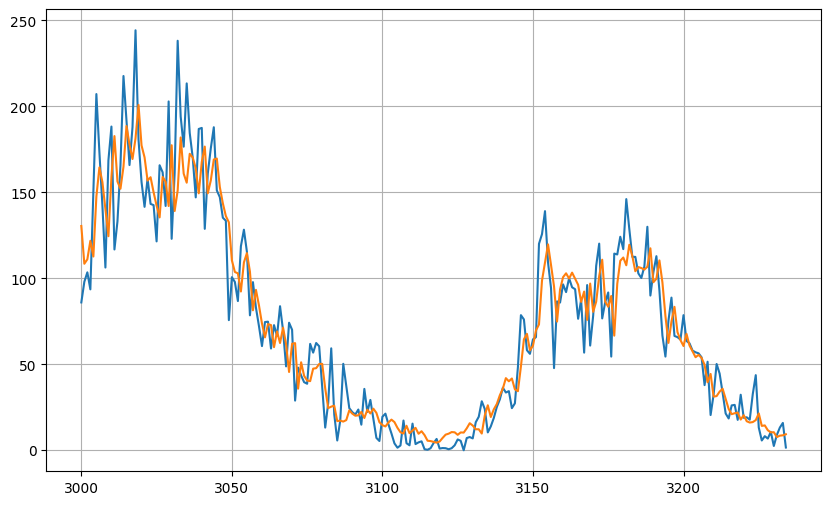

In [39]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [40]:
# Compute the MAE
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

14.262061